In [1]:
#Loading the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Loading the dataset
task2_path = '/content/sample_data/california_housing_train.csv'
raw_df = pd.read_csv(task2_path)

In [3]:
#Viewing the dataset
raw_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [4]:
#Creating a copy of the dataframe to work with
df = raw_df.copy()

# Task 2
Write a function in python that take dataframe as input and drop columns having Pearson correlation more than 0.85

In [5]:
#Method to view heatmap of a correlation matrix dataframe
def heatMap(df):
  upper = df.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))         #Creating dataframe out of the upper triangle of the correlation matrix
  plt.figure(figsize = (20, 15))
  s = sns.heatmap(upper,
                   annot = True, 
                   cmap = 'RdYlGn',
                   vmin = -1, 
                   vmax = 1)
  s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
  s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
  plt.title('Correlation Heatmap')
  plt.show()

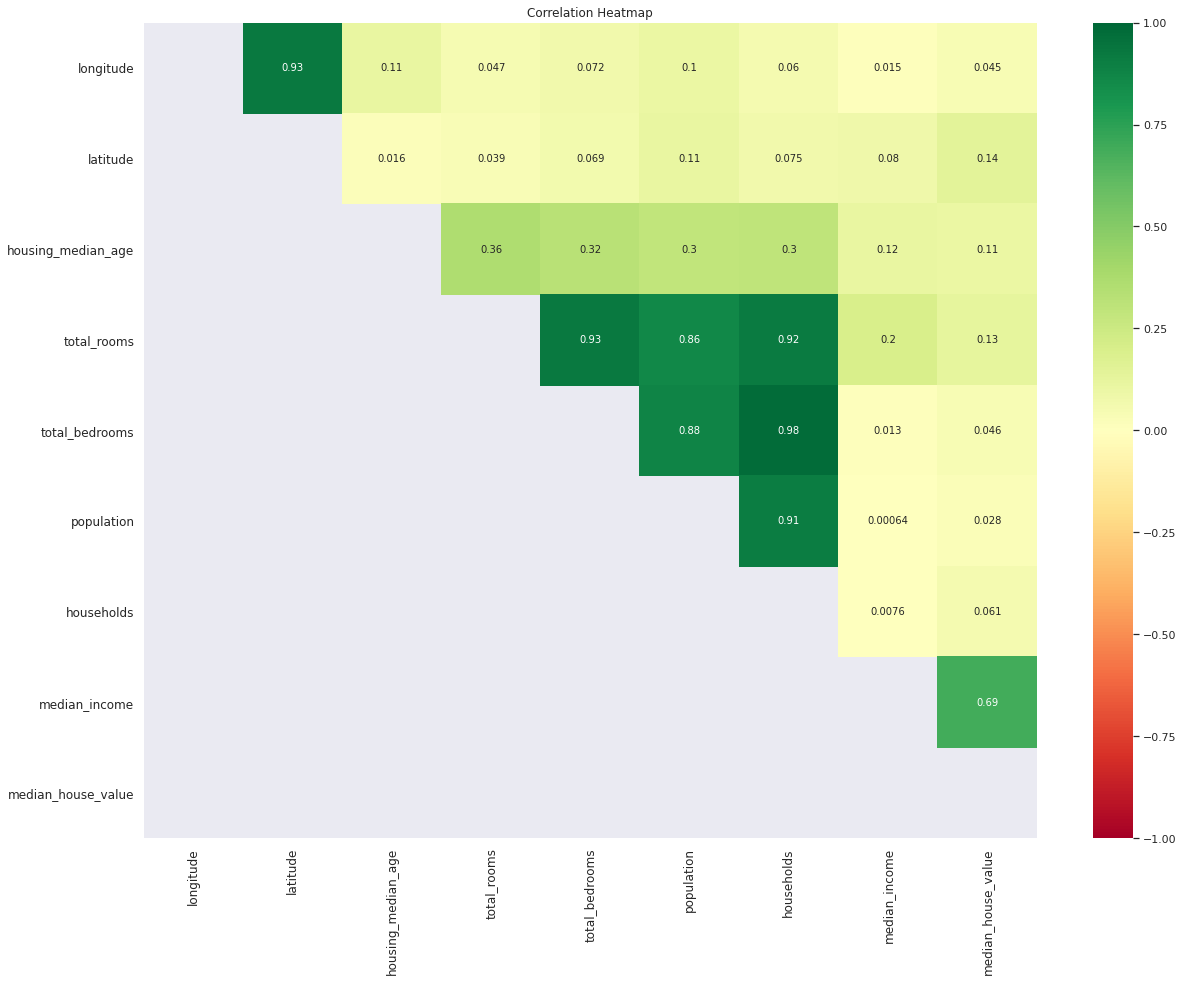

In [6]:
#Viewing the correlation matrix at the start
startCorrMatrix = df.corr(method='pearson', min_periods=30).abs()
#Calling method to display the heatmap
heatMap(startCorrMatrix)

In [7]:
#Method to create the variance inflation factor DataFrame
def vif(df):
  vif = pd.DataFrame()
  vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  vif["features"] = df.columns
  vif.sort_values(by = ["VIF Factor"], ascending=False, inplace = True)
  return vif

In [8]:
#Viewing the variance inflation factor
df_vif = vif(df)
df_vif

,VIF Factor,features
0,628.104059,longitude
1,565.859443,latitude
6,97.547879,households
4,97.190909,total_bedrooms
3,30.539308,total_rooms
5,17.594014,population
7,15.276260,median_income
8,10.073108,median_house_value
2,7.827488,housing_median_age


In [9]:
#Feature selection class to eliminate multicollinearity
class MultiCollinearityEliminator():
 
  #Class Constructor
  def __init__(self, df, target, threshold):
    self.df = df
    self.target = target
    self.threshold = threshold

  #Method to create and return the feature correlation matrix dataframe
  def createCorrMatrix(self, include_target = False):
    #Checking we should include the target in the correlation matrix
    if (include_target == False):
      df_temp = self.df.drop([self.target], axis =1)
      #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
      #Setting min_period to 30 for the sample size to be statistically significant (normal) according to central limit theorem
      corrMatrix = df_temp.corr(method='pearson', min_periods=30).abs()
    elif (include_target == True):
      corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
    return corrMatrix

  #Method to create and return the feature to target correlation matrix dataframe
  def createCorrMatrixWithTarget(self):
    #After obtaining the list of correlated features, this method will help to view which variables (in the list of correlated features) are least correlated with the target
    #This way, out the list of correlated features, we can ensure to elimate the feature that is least correlated with the target
    #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity

    corrMatrix = self.createCorrMatrix(include_target = True)                           #Obtaining the correlation matrix of the dataframe (along with the target)
    #Creating the required dataframe, then dropping the target row and sorting by the value of correlation with target (in asceding order)
    corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)                    
    return corrWithTarget

  #Method to create and return the list of correlated features
  def createCorrelatedFeaturesList(self):
    corrMatrix = self.createCorrMatrix(include_target = False)                          #Obtaining the correlation matrix of the dataframe (without the target)
    colCorr = []        
    for column in corrMatrix.columns:                                                   #Iterating through the columns of the correlation matrix dataframe
      for idx, row in corrMatrix.iterrows():                                            #Iterating through the values (row wise) of the correlation matrix dataframe
        if(row[column]>self.threshold) and (row[column]<1) and (idx not in colCorr):
          colCorr.append(idx)
    return colCorr

  #Method to eliminate the least important features from the list of correlated features
  def deleteFeatures(self):                                     
    corrWithTarget = self.createCorrMatrixWithTarget()                                  #Obtaining the feature to target correlation matrix dataframe
    colCorr = self.createCorrelatedFeaturesList()                                       #Obtaining the list of correlated features 
    for idx, row in corrWithTarget.iterrows():
      if (idx in colCorr):
        self.df = self.df.drop(idx, axis =1)
        break
    return self.df

  #Method to run automatically eliminate multicollinearity
  def autoEliminateMulticollinearity(self):
    corrMatrix = self.createCorrMatrix()                                                #Obtaining the correlation matrix of the dataframe   
    corrWithTarget = self.createCorrMatrixWithTarget()                                  #Obtaining the feature to target correlation matrix dataframe
    colCorr = self.createCorrelatedFeaturesList()                                       #Obtaining the list of correlated features
    while colCorr != []:
      self.df = self.deleteFeatures()                                                   #Obtaining the dataframe after deleting the feature (from the list of correlated features) that is least correlated with the taregt
      corrMatrix = self.createCorrMatrix()                                              #Obtaining the correlation matrix of the dataframe   
      corrWithTarget = self.createCorrMatrixWithTarget()                                #Obtaining the feature to target correlation matrix dataframe
      colCorr = self.createCorrelatedFeaturesList()                                     #Obtaining the list of correlated features
    return self.df

In [10]:
#Instantiating the custom made class to eliminate multicollinearity
multiCollinearityEliminator = MultiCollinearityEliminator(df, 'households', 0.85)

In [11]:
#Calling the method to eliminate multicollinearity and storing the preprocessed data frame
df_preprocessed = multiCollinearityEliminator.autoEliminateMulticollinearity()

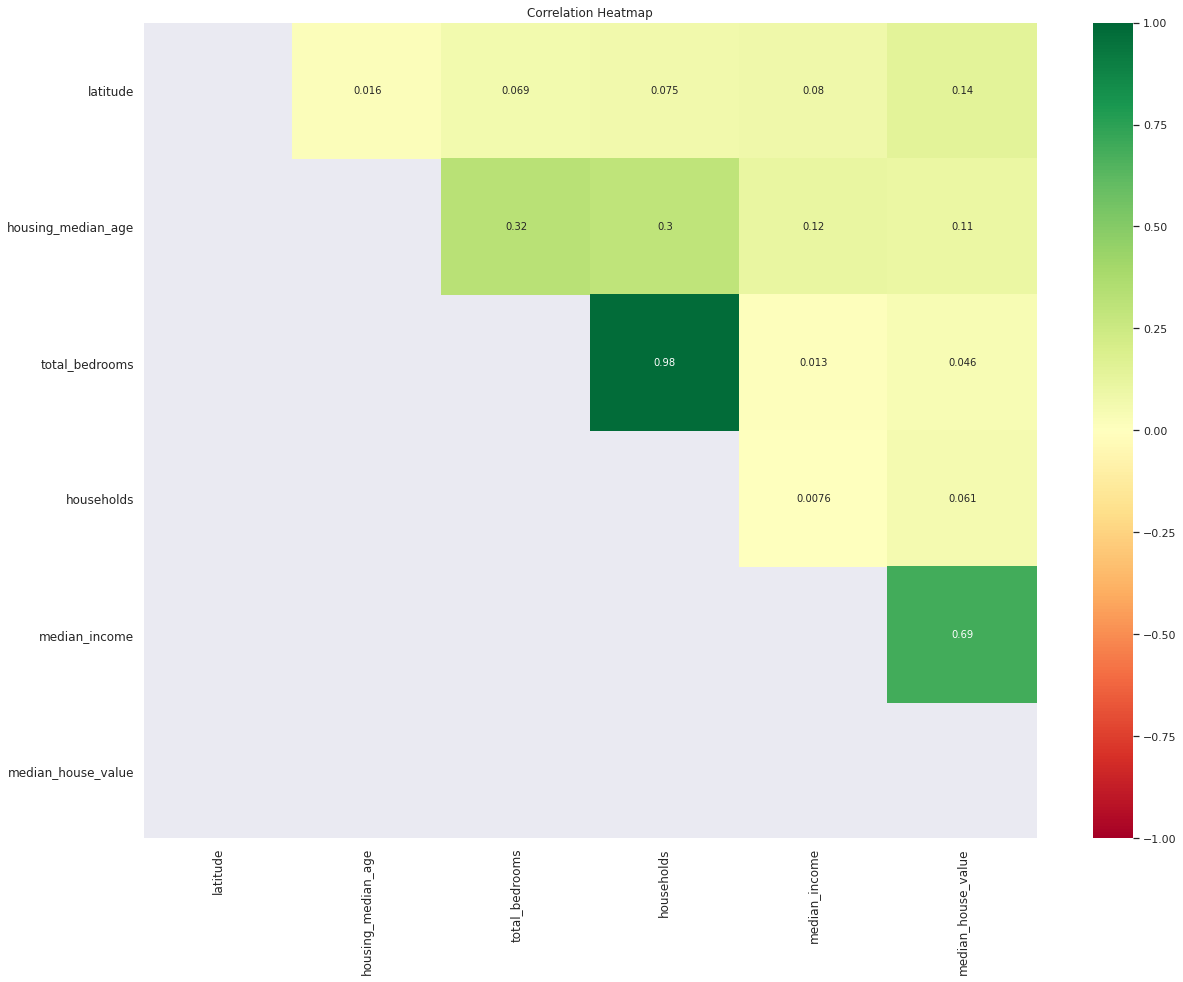

In [12]:
#Viewing the correlation matrix after preprocessing
finalCorrMatrix = df_preprocessed.corr(method='pearson', min_periods=30).abs()
#Calling method to display the heatmap
heatMap(finalCorrMatrix)

The autoML class has eliminated the least number and the least important features to eliminate multicollinearity in the data set above. The class has also ensured to not eliminate the features that are highly correlated with the target with a simple if else condition while creating the correlation matrix.

In [13]:
#Viewing the variance inflation factor
df_vif = vif(df_preprocessed)
df_vif

,VIF Factor,features
3,72.736551,households
2,72.200523,total_bedrooms
0,15.598837,latitude
4,10.912626,median_income
5,8.974564,median_house_value
1,7.541775,housing_median_age


Here, total_bedrooms is the only feature with high VIF. This is because it has high correlation with the target. The VIF for the next highest feature (latitude) has reduced from 566 to 16. This is an indicator of the efficiency of our code.

# Task 1
Write a function in python that inputs a dataframe and identify which columns have date in them. Using these date columns make new columns which are difference between these columns taking 2 at a time. (for instance if there is date1, date2, date3 columns, output should be like date1-date2, date2-date3, date1-date3).

In [14]:
#creating the dataframe
df_task1 = pd.DataFrame({'val1': [1,2,3], 'Date1': ['2015-12-27',np.NaN, '2015-12-29'], 'Date2': ['2017-11-7','2017-11-8', '2017-11-9'], 'val2': [4,5,6], 'Date3': ['2013-1-26','2014-5-6', '2018-3-5']})

In [15]:
df_task1

,val1,Date1,Date2,val2,Date3
0,1,2015-12-27,2017-11-7,4,2013-1-26
1,2,NaN,2017-11-8,5,2014-5-6
2,3,2015-12-29,2017-11-9,6,2018-3-5


In [16]:
#Displaying the data types of the columns
df_task1.dtypes

val1      int64
Date1    object
Date2    object
val2      int64
Date3    object
dtype: object

In [17]:
#Method to calculate time difference of date columns in dataframe
def timeDiff(df):
  #Converting object type columns to datetime format
  df = df.apply(lambda col: pd.to_datetime(col, errors='ignore') 
              if col.dtypes == object 
              else col, 
              axis=0)
  #Creating a list of all datetime columns
  l= [col for col in df.columns if (df[col].dtype=='<M8[ns]')]
  #Calculating time difference between pairs of datetime and taking the absolute value (as time cannot be negative)
  for i in range(len(l)):
    for j in range(i+1, len(l)):
      df[f'Date{i}{j}'] = df[l[i]] - df[l[j]]
      df[f'Date{i}{j}'] = df[f'Date{i}{j}'].abs()
  return df

In [18]:
#Calling method to calculate time difference of date columns in dataframe
final_df = timeDiff(df_task1)

In [19]:
final_df

,val1,Date1,Date2,val2,Date3,Date01,Date02,Date12
0,1,2015-12-27,2017-11-07,4,2013-01-26,681 days,1065 days,1746 days
1,2,NaT,2017-11-08,5,2014-05-06,NaT,NaT,1282 days
2,3,2015-12-29,2017-11-09,6,2018-03-05,681 days,797 days,116 days


In [20]:
#Displaying the data types of the columns
final_df.dtypes

val1                int64
Date1      datetime64[ns]
Date2      datetime64[ns]
val2                int64
Date3      datetime64[ns]
Date01    timedelta64[ns]
Date02    timedelta64[ns]
Date12    timedelta64[ns]
dtype: object